In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from matplotlib.image import imread


##### Loading and preprocessing the data

[[130 130 130 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 245 255]]
(61, 80)


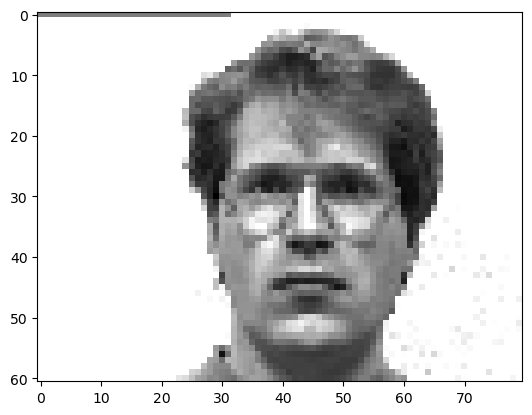

In [2]:
example = imread("data/yalefaces/subject01/subject01.glasses.gif")[::4,::4]
plt.imshow(example, cmap='grey')
print(example)
print(example.shape)
plt.show()

In [3]:
def face_matrix(path):
    img_list = []
    for file in glob.glob(path):

        image = imread(file)[::4,::4].reshape((1,4880)) #downsampling + reshape
   
        img_list.append(image)

    img_list = np.array(img_list) 
    img_list = np.squeeze(img_list)
    return img_list

In [4]:
subject01 = face_matrix("data/yalefaces/subject01/*.*")
subject01_mean = np.mean(subject01, axis=0)

subject02 = face_matrix("data/yalefaces/subject02/*.*") 
subject02_mean = np.mean(subject02, axis=0)


print("Subject01, each row represent an image: \n", subject01)


Subject01, each row represent an image: 
 [[130 130 130 ... 255 245 255]
 [130 130 130 ... 255 244 253]
 [130 130 130 ... 216 186 197]
 ...
 [130 130 130 ... 255 244 255]
 [130 130 130 ... 255 249 255]
 [130 130 130 ... 255 241 249]]


##### Plotting the first 6 eigenfaces for each subject

In [5]:
def center_arr(array):
    mu = np.mean(array, axis = 0)
    center_array = array - mu
    return center_array

In [ ]:
k = 6

#subject01
X1 = center_arr(subject01) 
U1,S1,V1 = np.linalg.svd(X1) 
top_k_1 = V1[:k,:].reshape(k,61,80)


#subject02
X2 = center_arr(subject02) 
U2,S2,V2 = np.linalg.svd(X2)
top_k_2 = V2[:k,:].reshape(k,61,80)

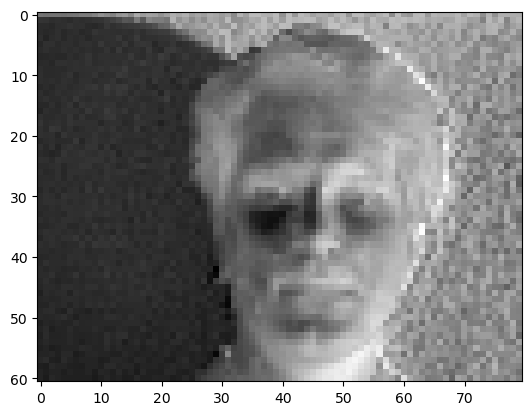

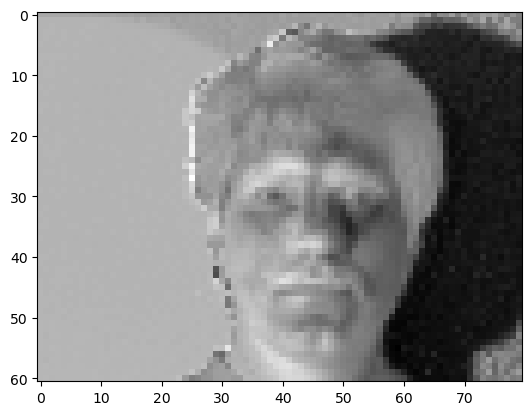

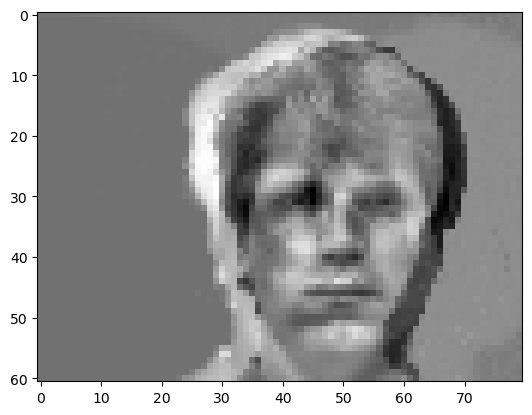

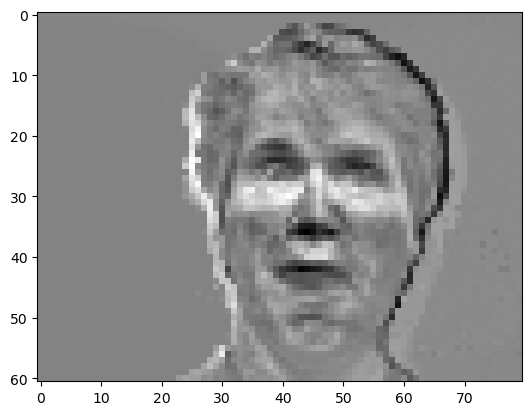

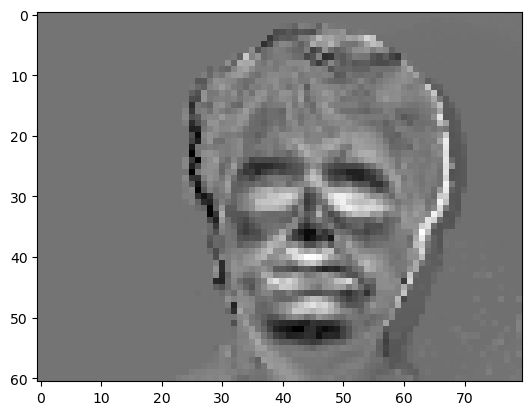

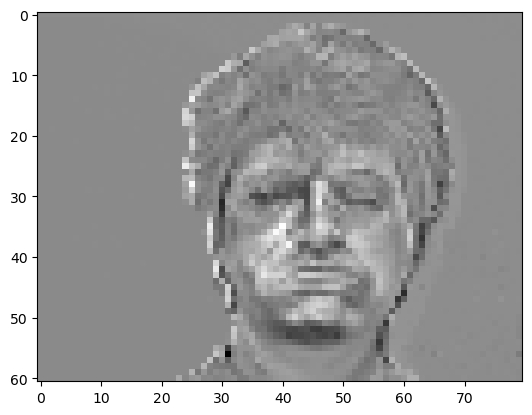

In [7]:
#subject01 eigenfaces
for i in top_k_1:
    plt.imshow(i,cmap = 'gray')
    plt.show()

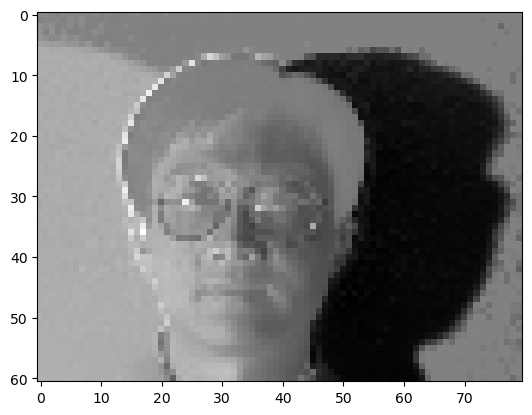

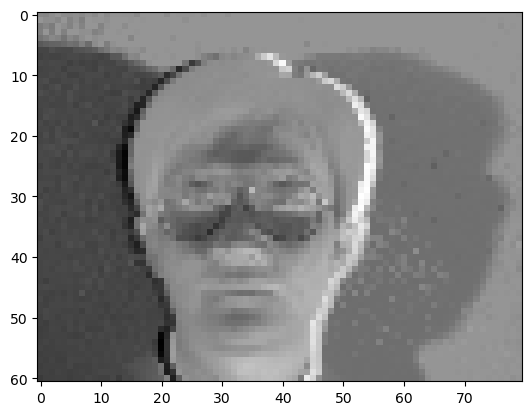

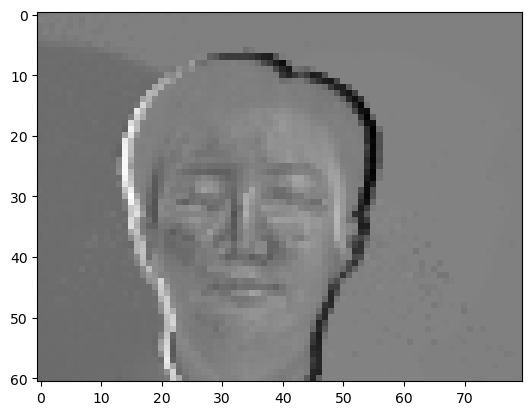

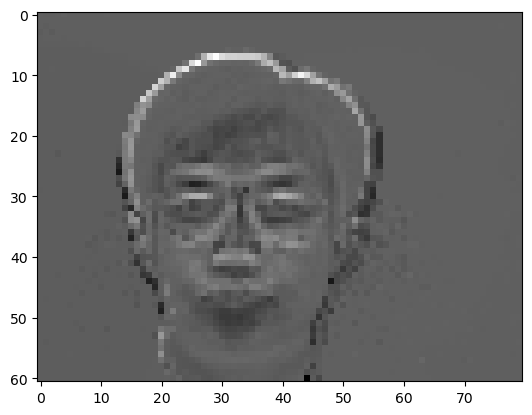

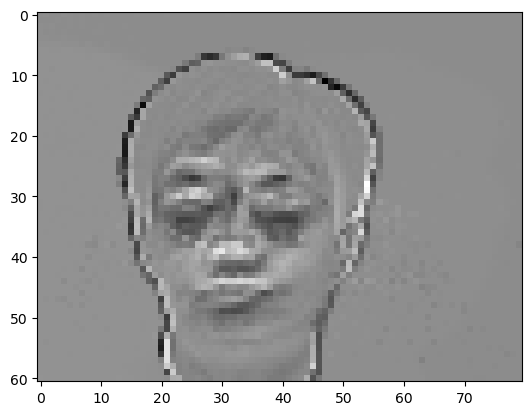

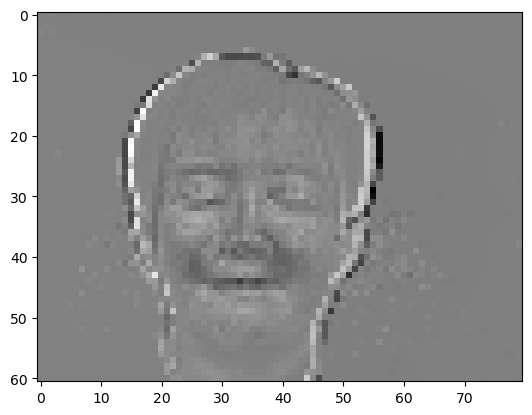

In [8]:
#subject02 eigenfaces
for i in top_k_2:
    plt.imshow(i,cmap = 'gray')
    plt.show()

 For both Subject 1 and Subject 2, the top two eigenfaces primarily capture variations in lighting. This is because the top eigenvectors represent the directions of greatest variance in the dataset, which suggests that the most significant differences arise from the lighting contrast across images.The middle and later eigenfaces seem to capture more variations in the head shape, facial features and expressions, such as changes in the eyes, mouth and nose.

##### Loading the test images

test image 1:


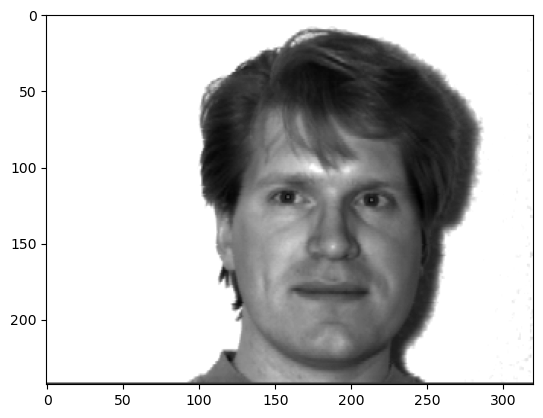




test image 2:


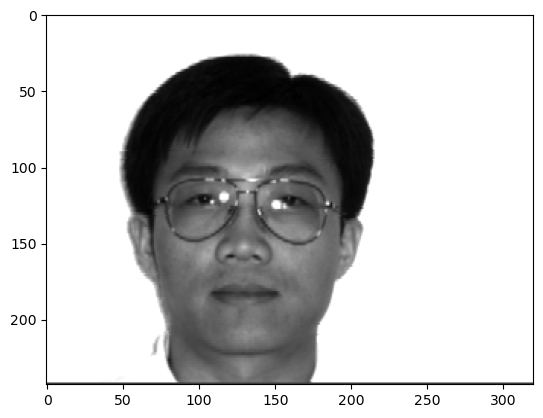

In [9]:
test_01= imread("data/yalefaces/test/subject01-test.gif")
print("test image 1:")
plt.imshow(test_01, cmap ='grey')
plt.show()
print("\n\n")

test_02 = imread("data/yalefaces/test/subject02-test.gif")
print("test image 2:")
plt.imshow(test_02, cmap ='grey')
plt.show()

test_01 = test_01[::4,::4].reshape(4880)
test_02 = test_02[::4,::4].reshape(4880)

##### Using the top 6 eigenfaces to calculate projection residual.

 Face recognition is performed using PCA by measuring how well each test image is represented within the eigenspace of Subject 1 and Subject 2.
 
 To classify the test images, the projection residual is computed. The projection residual is calculated as:
$$ s_{ij} = \| x_j - V_i (V_i^T x_j) \|_2^2 $$

where xj is the vectorized test image, Vi represents the eigenfaces of Subject i, and sij is the projection residual. A smaller residual indicates that the test image is better represented by the eigenfaces of that subject.

In [10]:
V_01 = (top_k_1[:,:]).reshape(k,4880)
V_02 = (top_k_2[:,:]).reshape(k,4880)

#centering the test data relative to each subject
center_test_11 = test_01-subject01_mean
center_test_21 = test_01-subject02_mean

center_test_12 = test_02-subject01_mean
center_test_22 = test_02-subject02_mean

In [11]:
#projection residual

#test image 01
s11 = np.linalg.norm(center_test_11 - (V_01.T@V_01) @ center_test_11)**2

s21 = np.linalg.norm(center_test_21 - (V_02.T@V_02) @ center_test_21)**2

print("Carrying test #1:")
print(f"s11 = {s11}, s21 = {s21}")

if s11 < s21:
    print("This is subject 01.\n\n")

else:
    print("This is subject 02.\n\n") 

#################################################################################

#test image 02
s12 = np.linalg.norm(center_test_12 - (V_01.T@V_01) @ center_test_12)**2

s22 = np.linalg.norm(center_test_22 - (V_02.T@V_02) @ center_test_22)**2

print("Carrying test #2:")
print(f"s12 = {s12}, s22 = {s22}")

if s12 < s22:
    print("This is subject 01.")

else:
    print("This is subject 02.") 

Carrying test #1:
s11 = 6091271.162235055, s21 = 31949175.64049546
This is subject 01.


Carrying test #2:
s12 = 35237267.936834805, s22 = 2560011.9287058096
This is subject 02.


 Since s11 < s21, Test Image 1 is classified as Subject 1. Conversely, since s12 > s22, Test Image 2 is classified as Subject 2. This confirms that the projection residual method correctly identifies each test image based on how well it fits into each subject’s eigenspace.

 Although the PCA algorithm successfully differentiates between Subject 1 and Subject 2, there is still room for improvement. One limitation is that the top two eigenfaces, which capture the directions of greatest variance in the dataset, primarily captures differences in lighting rather than facial features. This suggests that the algorithm is more sensitive to lighting changes than to the variations in facial features.
 
 A possible improvement would be to normalize lighting conditions before applying PCA, ensuring that the primary variations captured by the eigenfaces are more representative of facial structure rather than the lighting. Additionally, using a larger number of eigenfaces could help capture finer facial variations, allowing the algorithm to better distinguish between subjects based on facial features rather than lighting effects.